In [1]:

import numpy as np
import matplotlib.pyplot as plt
import h5py

from ssm.lds import SLDS
from sklearn.decomposition import PCA
import gc

def eval_model(data,predictions,mask=None):
  if mask is None:
    mask = np.ones(data['valid_behavior'][:].shape[0],dtype=bool)

  directions = data['valid_target_direction']
  unique_dirs = sorted(set(directions))

  R2 = np.empty((len(unique_dirs))) # directions
  for i,d in enumerate(unique_dirs):
    precision_error = (predictions[mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)])**2
    total_variance = (data['valid_behavior'][:][mask & (directions==d)] - data['valid_behavior'][:][mask & (directions==d)].mean(0))**2+1e-6
    R2[i] = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  R_UIVE = R2.mean() #uninstructed variance explained

  precision_error = (predictions[mask] - data['valid_behavior'][:][mask])**2
  total_variance = (data['valid_behavior'][:][mask] - data['valid_behavior'][:][mask].mean(0))**2
  vec_R2 = 1 - precision_error.sum()/total_variance.sum() # sum over trials and time and space
  return vec_R2,R_UIVE

Matplotlib created a temporary cache directory at /tmp/matplotlib-vlno8ih7 because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
data = h5py.File("../datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5", "r")
print(data.keys())
print(data["valid_recon_data"].shape)

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(116, 101, 70)


In [3]:
transitions = "standard"
emissions = "poisson"

dynamics_kwargs =  {'l2_penalty_A': 1000, 'l2_penalty_b': 1e-05}

N = data['train_encod_data'].shape[-1]
T = data['train_encod_data'].shape[1]
K = 4 # states
D = 50 # factors

alpha = 0.2
num_iters = 50

In [4]:
# ---- Run SLDS ---- #
slds = SLDS(N, K, D,
    transitions=transitions,
    emissions=emissions,
    emission_kwargs=dict(link="softplus"),
    dynamics_kwargs=dynamics_kwargs,
)

train_spikes, test_spikes = data['train_encod_data'], data['valid_encod_data']
train_datas = [train_spikes[i, :, :].astype(int) for i in range(len(train_spikes))]
test_datas = [test_spikes[i, :, :].astype(int) for i in range(len(test_spikes))]

train_datas, train_inputs, train_masks, train_tags = slds.prep_inputs(datas=train_datas)
eval_datas, eval_inputs, eval_masks, eval_tags = slds.prep_inputs(datas=test_datas)
gc.collect()

0

In [5]:
kwargs = {"method": "laplace_em", 
          "variational_posterior": "structured_meanfield", 
          "num_iters": num_iters, 
          "alpha": alpha}

q_elbos_lem_train, q_lem_train, *_ = slds.fit(
    datas=train_datas,
    inputs=train_inputs,
    masks=train_masks,
    tags=train_tags,
    initialize=True,
    num_init_iters=50,
    **kwargs
)

q_elbos_lem_eval, q_lem_eval, *_ = slds.approximate_posterior(
    datas=eval_datas, 
    inputs=eval_inputs,
    masks=eval_masks,
    tags=eval_tags,
    **kwargs
)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 50 steps of EM.


/disk/scratch2/nkudryas/BAND-torch/Lukes_Longitudinal_Data/ssm/ssm/observations.py:1039: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  ExuxuTs[k, -1, :D] = ExuxuTs[k, :D, -1].T


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# save slds object in pkl
import pickle
with open('chewie_slds.pkl', 'wb') as f:
    pickle.dump({'slds': slds, 
                 'q_elbos_lem_train': q_elbos_lem_train,
                    'q_lem_train': q_lem_train, 
                    'q_elbos_lem_eval': q_elbos_lem_eval,
                    'q_lem_eval': q_lem_eval
                 }, f)
# # load pickle
# with open('chewie_slds.pkl', 'rb') as f:
#     slds_dict = pickle.load(f)
#     slds = slds_dict['slds']
#     q_elbos_lem_train = slds_dict['q_elbos_lem_train']
#     q_lem_train = slds_dict['q_lem_train']
#     q_elbos_lem_eval = slds_dict['q_elbos_lem_eval']
#     q_lem_eval = slds_dict['q_lem_eval']

In [ ]:
# decode behavior from factors
train_factors = q_lem_train.mean_continuous_states
eval_factors = q_lem_eval.mean_continuous_states

from sklearn.linear_model import Ridge

Y_train = data['train_behavior'][:].reshape(data['train_behavior'][:].shape[0],-1)
X_train = train_factors.reshape(train_factors.shape[0],-1)
X_test = eval_factors.reshape(eval_factors.shape[0],-1)
ridge = Ridge(alpha=1).fit(X_train, Y_train)
Y_pred = ridge.predict(X_test).reshape(data['valid_behavior'][:].shape)


In [50]:
eval_model(data,Y_pred)

(0.6986512804700277, -1.2430961458361551)

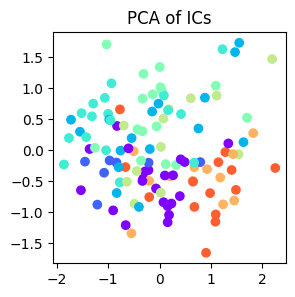

In [74]:
dset='valid'
vel = data[f'{dset}_behavior'][:]
target_direction = data[f'{dset}_target_direction'][:]
epoch = data[f'{dset}_epoch'][:]
pos = np.cumsum(vel, axis=1)

dir_index = np.array([
        sorted(set(target_direction)).index(i) for i in target_direction
    ])

ICs = q_lem_eval.mean_continuous_states[:,0]
# plot PCA of ICs
pca = PCA(n_components=2)
ICs_pca = pca.fit_transform(ICs)
plt.figure(figsize=(3,3))
plt.scatter(ICs_pca[:,0],ICs_pca[:,1],c = cm.rainbow(dir_index/8))   
# plt.colorbar()
plt.title('PCA of ICs')
plt.show()



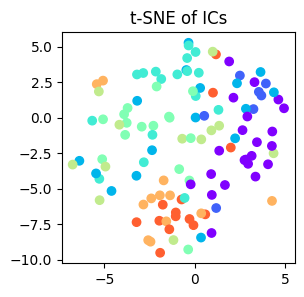

In [75]:
#t-SNE of ICs
from sklearn.manifold import TSNE
import matplotlib.cm as cm

tsne = TSNE(n_components=2)
ICs_tsne = tsne.fit_transform(ICs)
plt.figure(figsize=(3,3))
plt.scatter(ICs_tsne[:,0],ICs_tsne[:,1],c = cm.rainbow(dir_index/8))   
plt.title('t-SNE of ICs')
plt.show()

In [58]:
np.unique(dir_index,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([22,  7, 16, 17, 16, 12, 12, 14]))